## Download and Import Required modules

In [1]:
!pip install alpha_vantage
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from alpha_vantage.techindicators import TechIndicators
import seaborn as sb

## Obtain the Necessary Data using the API

In [2]:
# replace with your own API key
kkey = 'YEWIOG54S98KWCOO'
stock = str(input("What stocks are you looking at (please key in the corresponding stock symbol eg. AAPL, SPY)  :  "))


ts = TimeSeries(key = kkey, output_format='pandas')
data, meta = ts.get_daily(stock, outputsize='full')

#clean and set date as index 
data = data.reset_index()
data = data.sort_values(by=['date'],ascending = True)
data = data.set_index("date") 


#extract closing price and visualise
closingprice = data[['4. close']]


#Same for Bollinger BAnds
ti = TechIndicators(key='YEWIOG54S98KWCOO', output_format='pandas')
bbandsdata, meta = ti.get_bbands(symbol = stock, interval='daily', time_period=20, series_type='close')
bbandsdata = bbandsdata.reset_index()
bbandsdata = bbandsdata.sort_values(by=['date'],ascending = True)
bbandsdata = bbandsdata.set_index("date") 


#Same for RSI
ti = TechIndicators(key='YEWIOG54S98KWCOO', output_format='pandas')
rsi, meta = ti.get_rsi(symbol = stock, interval='daily', time_period=20, series_type='close')
rsi = rsi.reset_index()
rsi = rsi.sort_values(by=['date'],ascending = True)
rsi = rsi.set_index("date") 


closingprice


What stocks are you looking at (please key in the corresponding stock symbol eg. AAPL, SPY)  :  SPY


,4. close
date,
1999-11-01,135.5625
1999-11-02,134.5937
1999-11-03,135.5000
1999-11-04,136.5312
1999-11-05,137.8750
...,...
2021-04-16,417.2600
2021-04-19,415.2100
2021-04-20,412.1700


## Visualise the Data gain appropriate insights

Text(0.5, 1.0, 'RSI')

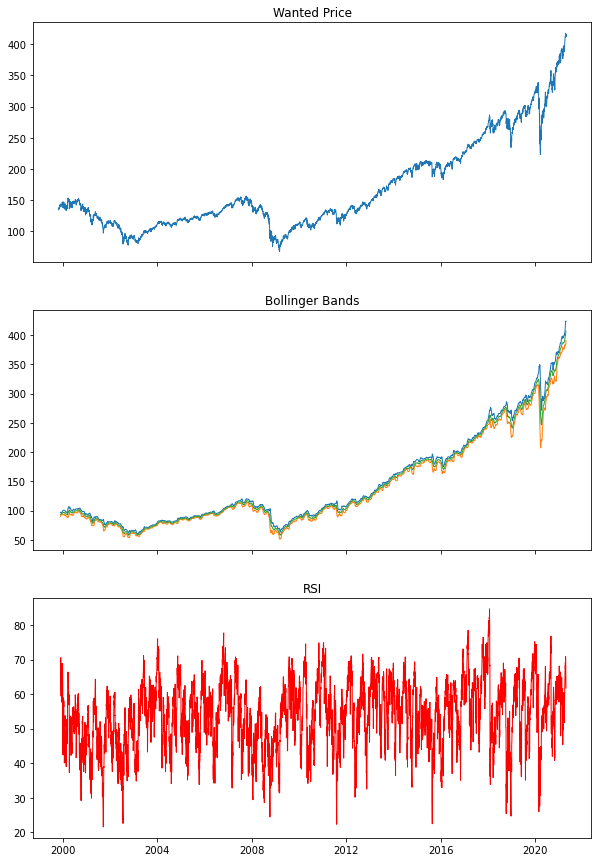

In [3]:
#visualising Data
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize = (10,15))

axs[0].plot(closingprice,linewidth =1)
axs[0].set_title('Wanted Price')
axs[1].plot(bbandsdata, linewidth =1)
axs[1].set_title('Bollinger Bands')
axs[2].plot(rsi,linewidth = 1, color = 'red')
axs[2].set_title('RSI')





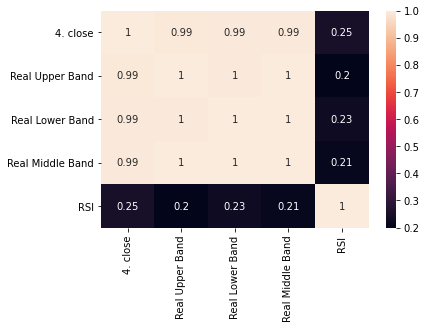

In [4]:
corrMatrix = pd.concat([closingprice,bbandsdata,rsi], axis=1).corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()


## Function For data Cleaning

In [5]:
import datetime as dt
from dateutil.relativedelta import relativedelta

#Function to clean out a singlecolumn information eg, closeprice/openprice in to the format needed. 
def dataclean(dataframe):

    dataframe['date'] = dataframe.index.date
    dataframe['date'] = pd.to_datetime(dataframe.date,format = "%Y-%m-%d")

    startdate = "2005-01-01"

    startdate = dt.datetime.strptime(startdate, "%Y-%m-%d")

    #startdate = startdate + relativedelta(months=+4)
    enddate =startdate + relativedelta(months=+2) - dt.timedelta(days = 1)
    
    mask = (dataframe['date']>=startdate) & (dataframe['date']<=enddate)

    a = []
    a.append(dataframe.loc[mask])

    jan = pd.DataFrame(np.row_stack(a))
    jan.rename(columns = {0:"jan",1:"date"},inplace=True)
    jan=jan[["date","jan"]]
    jan = jan.rename(columns={"jan":"2005-01"})
    #print(enddate)


    for x in range(35):
   
        startdate = startdate + relativedelta(months=+2)
        enddate =startdate + relativedelta(months=+2) - dt.timedelta(days = 1)
    
        mask = (dataframe['date']>=startdate) & (dataframe['date']<= enddate)
    
   
        b = []
        b.append(dataframe.loc[mask])
        feb  = pd.DataFrame(np.row_stack(b))
        feb.rename(columns = {0:"closingprice",1:"date"},inplace=True)
        feb.drop(['date'], axis='columns', inplace=True)
        jan[x] = feb
        #print("startdate",startdate)
        #print("endndate",enddate)
        jan = jan.rename(columns={x: startdate.strftime("%Y-%m")})
        b = []
        del feb
    jan = jan.drop(jan.columns[0], axis=1)
    jan.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
        
    return(jan)

## Functions For Linear Regression

In [6]:
def linearregression():
    
    predictionslist =[]
    actuallist = []
    explainedVariance =[]
    lr = LinearRegression()
   
#getting the X and Y values for fitting and prediction, past 2 months and next 2 months, ie (March-April) = B*(Jan-Feb) + E
    for i in range(len(closeprice.columns)-1):
        X = pd.DataFrame(closeprice.iloc[:,i])
        Y = pd.DataFrame(closeprice.iloc[:,i+1])
        X2 = pd.DataFrame(rsi.iloc[:,i])
        X3 = pd.DataFrame(bbandsdata2.iloc[:,i])
    
        X = pd.concat([X,X2,X3],axis =1)
        
        Y2 = pd.DataFrame(rsi.iloc[:,i+1])
        Y3 = pd.DataFrame(bbandsdata2.iloc[:,i+1])
        Z = pd.concat([Y,Y2,Y3],axis =1)
        linreg = lr.fit(X,Y)
        predictionslist.append(linreg.predict(Z))
        explainedVariance.append(linreg.score(X,Y))
     
    
    for i in range(2,len(closeprice.columns)):
        actuallist.append(np.array(closeprice.iloc[:,i]))
        
    return(predictionslist,actuallist,explainedVariance)

        
def plotpredictions(month,actual,predictions,explainedVariance):
    if(month == 19):
        print("\nAvg Explained Variance R^2 : ",sum(explainedVariance)/len(explainedVariance),"\n")
        print("----------------------------------------------------------------------------------\n")
        for i in range(len(actual)):
            
            plt.title("predictions for: "+str(closeprice.columns[i+1]))
            plt.plot(predictions[i],color = 'red',label = 'prediction')
            plt.plot(actual[i],color = 'blue',label = 'actual')
            plt.legend()
            plt.show()
            print("Explained Variance R^2 : ",explainedVariance[i],"\n")
        
    else:    
        plt.plot(predictions[indexes[month-1]-1],color = 'red',label = 'prediction')
        plt.plot(actual[indexes[month-1]-1],color = 'blue',label = 'actual')
        plt.legend()
        plt.show()
        print("Explained Variance R^2: ",explainedVariance[indexes[month-1]-1],"\n")


        # Plot the Linear Regression line
        plt.title("Linear Regresssion Line")
        plt.scatter(actual[indexes[month-1]-1], predictions[indexes[month-1]-1], color = "blue")
        plt.plot(actual[indexes[month-1]-1], actual[indexes[month-1]-1],color = 'r', linewidth = 1)


## Function For BackTesting

In [7]:
def backtest(closeprice,predictionslist):
    profits = []
    bought = []
    sold = []

    for i in range(len(closeprice.columns)):

        if(i>1):
            #print((closeprice.iloc[:,i-1]).iloc[0])
            #print(predictionslist[i-2][-1])
            if(predictionslist[i-2][-1]-(closeprice.iloc[:,i-1]).iloc[0]>1):
                #print("buy");
                profits2 = (closeprice.iloc[:,i]).iloc[-1] - (closeprice.iloc[:,i-1]).iloc[0]
                #print("profits: =",(closeprice.iloc[:,i]).iloc[-1], " - ", (closeprice.iloc[:,i-1]).iloc[0], " = :",profits2)
                profits.append((closeprice.iloc[:,i]).iloc[-1] - (closeprice.iloc[:,i-1]).iloc[0])
                bought.append(i-1)
                sold.append(i)
    return profits,bought,sold
            
   
        

## Function for Printing Results

In [8]:
def printresult(dates,bought,profits,closeprice):
    indexes =[]
    p=0
    l=0

    for i in range(len(profits)):
      if(profits[i-1]>0):
        p = p+1
      if(profits[i-1]<0):
        l = l+1

    print("\t\t     BackTest Results from 2005 to 2010 :")
    print("\t\t\t\t\t1000 shares per trade")
    print("---------------------------------------------------------------------------------------------------------------")
    print("Total Profit From",dates[0],"to",dates[len(dates)-1],": \t","$",1000*np.round(sum(profits), 3))
    print("Number of Profits: ", p )
    print("Number of Losses: ", l )
    print("Profit rate:", round(p/(l+p)*100, 3),"%")
    print("\n")

    for i in range(len(profits)):
        print("from",dates[bought[i]], "to", dates[sold[i]])
        print("bought: \t",(closeprice.iloc[:,bought[i]]).iloc[0])
        print("sold:   \t",(closeprice.iloc[:,sold[i]]).iloc[-1])
        print("Profit: \t","$",1000*np.round(profits[i], 3))
        print("\n")
        indexes.append(bought[i])
    return indexes

def userinput(profits,bought,dates):
    print("Which predictions of trade executed would u like to view:\n")

    for i in range(len(profits)):
        print(i+1,")","from",dates[bought[i]], "to", dates[sold[i]])
        print("\n")
    print(i+2,")","ALL predictions")
    month = int(input())
    return month

## MAIN 

In [9]:
#doing data cleaning and transform dataframe to 4months of data/column.
closeprice = dataclean(closingprice)
bbandsdata2 = bbandsdata[['Real Lower Band']]
bbandsdata2 = dataclean(bbandsdata2)
rsi = dataclean(rsi)

#obtaining linear regression results
predictions,actual,explainedVariance = linearregression()
profits,bought,sold = backtest(closeprice,predictions)

dates = list(closeprice.columns)

indexes = printresult(dates,bought,profits,closeprice)
closeprice

<ipython-input-5-6f7bc370edd7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = dataframe.index.date
<ipython-input-5-6f7bc370edd7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = pd.to_datetime(dataframe.date,format = "%Y-%m-%d")
<ipython-input-5-6f7bc370edd7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

		     BackTest Results from 2005 to 2010 :
					1000 shares per trade
---------------------------------------------------------------------------------------------------------------
Total Profit From 2005-01 to 2010-11 : 	 $ 71020.0
Number of Profits:  13
Number of Losses:  5
Profit rate: 72.222 %


from 2005-07 to 2005-09
bought: 	 119.53
sold:   	 119.72
Profit: 	 $ 190.0


from 2005-11 to 2006-01
bought: 	 120.49
sold:   	 129.46
Profit: 	 $ 8970.0


from 2006-05 to 2006-07
bought: 	 130.4
sold:   	 129.65
Profit: 	 $ -750.0


from 2006-09 to 2006-11
bought: 	 131.42
sold:   	 141.58
Profit: 	 $ 10160.0


from 2006-11 to 2007-01
bought: 	 136.86
sold:   	 139.5
Profit: 	 $ 2640.0


from 2007-01 to 2007-03
bought: 	 141.37
sold:   	 148.12
Profit: 	 $ 6750.0


from 2007-03 to 2007-05
bought: 	 140.51
sold:   	 150.55
Profit: 	 $ 10040.0


from 2008-03 to 2008-05
bought: 	 133.5
sold:   	 131.19
Profit: 	 $ -2310.0


from 2008-09 to 2008-11
bought: 	 127.99
sold:   	 87.16
Profit: 	 

,2005-01,2005-03,2005-05,2005-07,2005-09,2005-11,2006-01,2006-03,2006-05,2006-07,...,2009-05,2009-07,2009-09,2009-11,2010-01,2010-03,2010-05,2010-07,2010-09,2010-11
0,120.3,121.23,116.4,119.53,122.49,120.49,126.7,129.37,130.4,127.8,...,87.89,92.33,100.2,104.32,113.33,111.89,120.35,102.76,108.46,118.53
1,118.83,121.17,116.6,120.49,122.27,121.75,127.3,129.36,131.38,127.07,...,90.88,89.81,99.82,104.65,113.63,112.2,117.52,102.2,109.47,119.47
2,118.01,121.22,117.5,119.48,123.7,122.27,127.38,128.76,130.89,127.44,...,90.57,89.8,100.65,104.92,113.71,112.3,116.82,102.87,110.89,119.95
3,118.61,122.73,117.46,119.95,123.91,122.11,128.44,128.17,131.36,126.61,...,92.14,88.06,102.06,106.85,114.19,112.64,112.94,106.11,109.64,122.26
4,118.44,122.79,117.09,121.32,123.5,122.23,128.77,127.97,132.52,126.85,...,90.86,88,102.94,107.13,114.57,114.25,111.26,107.16,110.41,122.72
5,119,122.33,117.82,121.94,124.6,122.23,128.9,128.24,132.36,127.41,...,92.98,88.17,103.73,109.57,114.73,114.27,116.16,107.96,110.92,122.49
6,118.18,120.97,116.6,122.26,124.35,122.39,129.31,127.38,132.62,126.05,...,91.24,87.96,104.79,109.59,113.66,114.46,115.83,108.03,111.48,121.61
7,118.57,121.24,117.24,122.43,123.66,123.34,128.8,128.59,132.55,124,...,90.97,90.1,104.77,110.15,114.62,114.97,117.45,109.66,112.72,122.1
8,117.62,120.39,115.95,122.91,123.21,123.76,128.68,128.83,130.95,123.52,...,88.68,90.61,105.28,109.03,114.93,115.45,115.99,109.65,112.65,121.64
9,118.24,121.14,115.72,122.84,123.15,123.69,128.33,130.18,129.24,123.34,...,89.44,93.26,105.72,109.62,113.64,115.46,113.89,109.68,113.08,120.2


In [10]:
month = userinput(profits,bought,dates)

Which predictions of trade executed would u like to view:

1 ) from 2005-07 to 2005-09


2 ) from 2005-11 to 2006-01


3 ) from 2006-05 to 2006-07


4 ) from 2006-09 to 2006-11


5 ) from 2006-11 to 2007-01


6 ) from 2007-01 to 2007-03


7 ) from 2007-03 to 2007-05


8 ) from 2008-03 to 2008-05


9 ) from 2008-09 to 2008-11


10 ) from 2008-11 to 2009-01


11 ) from 2009-03 to 2009-05


12 ) from 2009-05 to 2009-07


13 ) from 2009-07 to 2009-09


14 ) from 2009-09 to 2009-11


15 ) from 2009-11 to 2010-01


16 ) from 2010-03 to 2010-05


17 ) from 2010-07 to 2010-09


18 ) from 2010-09 to 2010-11


19 ) ALL predictions
14


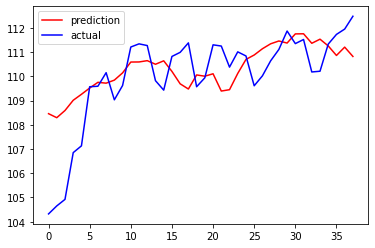

Explained Variance R^2:  0.514314512223555 



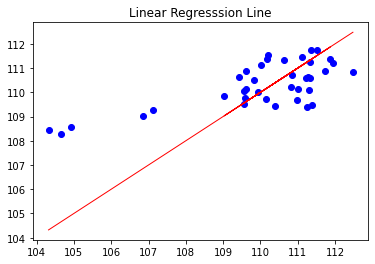

In [11]:
plotpredictions(month,actual,predictions,explainedVariance)

In [12]:
p=0
l=0
np= 0
nl =0


for i in range((len(profits))):
  if(profits[i]>0):
    p = p+profits[i]
    np = np+1
  if(profits[i]<0):
    l= l+profits[i]
    nl = nl+1
  

<AxesSubplot:title={'center':'profits'}>

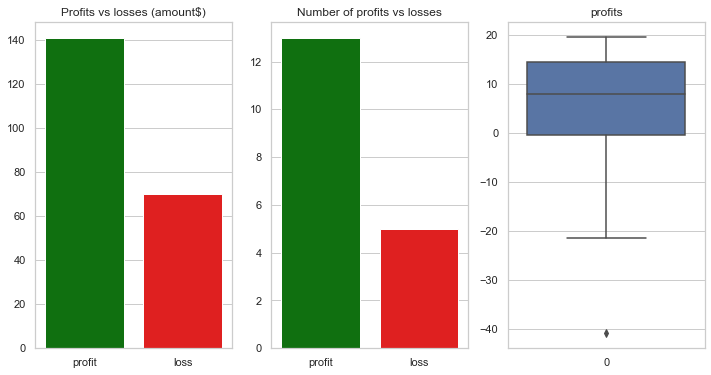

In [13]:
#just some simple visualisation of results.
yaxis = [p,abs(l)]
y2 = [np,nl]
xaxis=["profit","loss"]


sb.set_theme(style="whitegrid")
clrs = ['green','red']
fig, axes = plt.subplots(1, 3,figsize = (12,6))
axes[0].set_title('Profits vs losses (amount$)')
axes[1].set_title('Number of profits vs losses')
axes[2].set_title('profits')
sb.barplot(ax = axes[0], x = xaxis, y = yaxis,palette = clrs)
sb.barplot(ax = axes[1],x = xaxis, y = y2,palette = clrs)
sb.boxplot(ax = axes[2], data = profits)


